In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
 
assert torch.__version__ != None, "Pytorch is not working correctly"

# Recurrent neural network
One of the way to work with the sequences without fixed size is RNN. The main idea - divide sequence into tokens(parts) and give it to nn that is recurrently using its output again in input saving context as matrix $h$, in other words - captures information about the sequence seen so far. 
Often they suffer from the vanishing or exploding gradient problem

In [257]:
import requests

# Using requests to get dataset and save it
url = 'https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/week0_09_embeddings_and_seq2seq/names'
response = requests.get(url)

with open('names', 'wb') as file:
    file.write(response.content)

In [258]:
import os
start_token = " "

# Converting data from names.txt to list in python
with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + line for line in names]

# Overall information
print ('total_samples = {}, type = {}'.format(len(names), type(names)))

# Printing every 1000th name
for x in names[::1000]:
    print (x)

total_samples = 7944, type = <class 'list'>
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


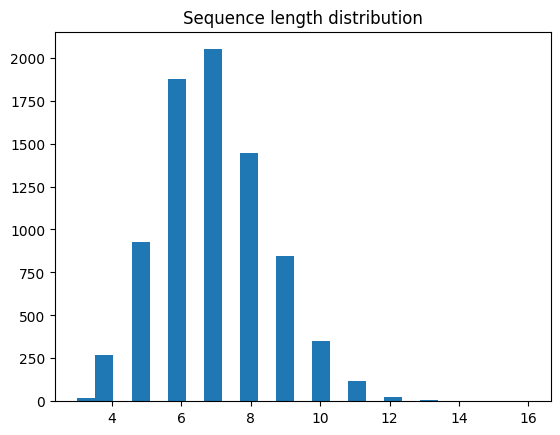

In [259]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);

Our task here is to predict token with condition that we have already seen some numbers of tokens. Our tokens here - letters, symbols.
We have symbols like (-,) because there are names like Sho-Den and etc.

In [260]:
#all unique characters go here
tokens = set()
for name in names:
    for c in name:
        tokens.add(c)

print(tokens)
tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

{'p', 'S', 'd', 'Z', 'H', 'g', 'n', 'l', 'q', 'f', 's', 'X', 'v', 'K', 'a', 'I', 'r', 'C', 'w', 'h', 'F', 'A', 'V', 'B', 'e', 'O', 'P', 'k', 'U', '-', 'i', 'y', 'u', 'm', 't', 'z', 'c', 'M', 'Q', 'N', 'R', 'L', 'o', 'E', "'", ' ', 'D', 'G', 'j', 'b', 'x', 'J', 'T', 'W', 'Y'}
num_tokens =  55


# Convert characters to integers
Torch can work only with numbers, so we need to convert our tokens into numbers: it will be our $TokenToId$

Its good practice in NLP to use special tokens for start and end of sequence

In [261]:
tokens.append('<') # <StartOfSequence>
tokens.append('>') # <EndOfSequence>
tokens.append('_') # <Padding>

In [262]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print(token_to_id)
print("Everything is fine")

{'p': 0, 'S': 1, 'd': 2, 'Z': 3, 'H': 4, 'g': 5, 'n': 6, 'l': 7, 'q': 8, 'f': 9, 's': 10, 'X': 11, 'v': 12, 'K': 13, 'a': 14, 'I': 15, 'r': 16, 'C': 17, 'w': 18, 'h': 19, 'F': 20, 'A': 21, 'V': 22, 'B': 23, 'e': 24, 'O': 25, 'P': 26, 'k': 27, 'U': 28, '-': 29, 'i': 30, 'y': 31, 'u': 32, 'm': 33, 't': 34, 'z': 35, 'c': 36, 'M': 37, 'Q': 38, 'N': 39, 'R': 40, 'L': 41, 'o': 42, 'E': 43, "'": 44, ' ': 45, 'D': 46, 'G': 47, 'j': 48, 'b': 49, 'x': 50, 'J': 51, 'T': 52, 'W': 53, 'Y': 54, '<': 55, '>': 56, '_': 57}
Everything is fine


Function below converts sequences into matrix representation like we take several number of sequences and enlarge them to determined length using pad-token. We need it in order for sequences to be the same size

In [263]:
def to_matrix(names, max_len=None, pad=token_to_id['_'], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    #Take max length among all sequences or determined max length
    max_len = max_len or max(map(len, names))
    max_len += 1
    names_ix = np.zeros([len(names), max_len], dtype) + pad
    # Adding token - start of sequence
    names_ix[:, 0] = token_to_id['<']

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, 1:len(line_ix)] = line_ix[1:]
        # Adding token - end of sequence
        names_ix[i, len(line_ix)] = token_to_id['>']
    
    # We need time here because order of tokens in sequence is very important
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [264]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))
print([(i, token_to_id[i]) for i in ('<','>','_')])

 Abagael
 Glory
 Prissie
 Giovanne
[[55 21 49 14  5 14 24  7 56 57]
 [55 47  7 42 16 31 56 57 57 57]
 [55 26 16 30 10 10 30 24 56 57]
 [55 47 30 42 12 14  6  6 24 56]]
[('<', 55), ('>', 56), ('_', 57)]


We can see that our sequences are starting with 55 - start of sequence and ending either with 57 or 56 according to if the name is takes the whole length or not

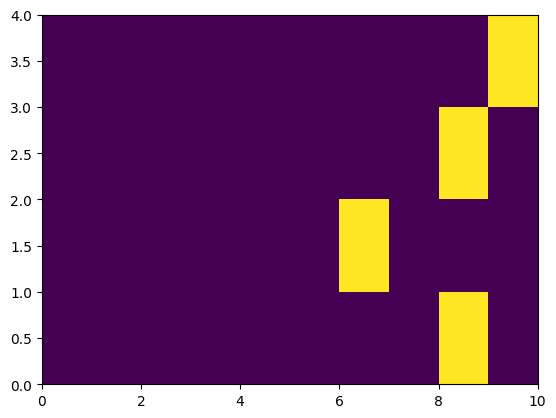

In [265]:
# Where our sequences ends 
plt.pcolormesh(to_matrix(names[::2000]) == 56)

There are already implemented RNN models in torch but let`s make our own model for better understanding

Here we are using embedding to make our 1hot_vectors more informative by creating new matrix of weigths. We can see that this (matrix matmul 1hot_vector) is actually taking certain rows according to 1hot_vector. Overall embedding is converts out input into vector representation. The main advantage is we are working with low dimensional and informative vectors/matrix.

In [266]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim = 1)
        h_next = self.rnn_update( x_and_h )
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        # output: current state of RNN and logits to calculate loss function in the future
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [267]:
char_rnn = CharRNNCell()

In [268]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logits.append(logits_next)
        
    return torch.stack(logits, dim=1)

In [269]:
num_tokens = len(tokens)

In [270]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logit_seq = rnn_loop(char_rnn, batch_ix)

# assert torch.max(logit_seq).data.numpy() <= 0
# assert tuple(logit_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [271]:
predictions_logits = logit_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

# logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])
loss = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )

print(loss)
loss.backward()
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

tensor(4.1200, grad_fn=<NllLossBackward0>)


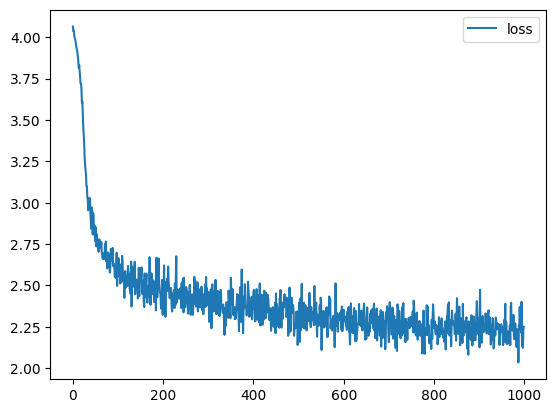

In [272]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, : -1]
    actual_next_tokens = batch_ix[:, 1 :]

    loss = loss_func(
    predictions_logp.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )

    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # vusialization
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

# Generating new names

In [273]:
def generate_sample(char_rnn, seed_phrase='<', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        if next_ix == token_to_id['>']:
          break
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

<BarContainer object of 6 artists>

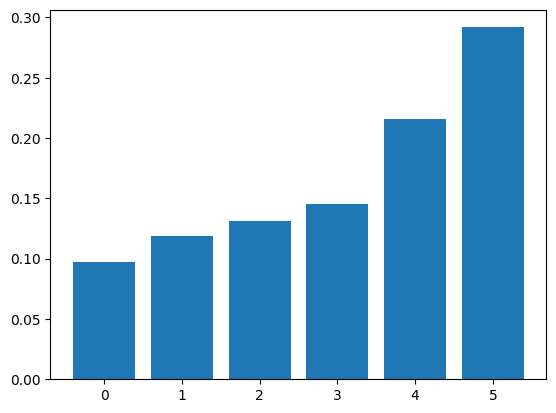

In [274]:
# Temperature
def softmax(x, temp=1.):
    exps = np.exp((x - x.max()) / temp)
    return exps / exps.sum()

plt.bar(np.arange(6), softmax(np.array([1, 3 , 4, 5, 9, 12]), 10))

In [275]:
for _ in range(10):
    print(generate_sample(char_rnn)[1:-1])

qaalon
Taroilod
Olein
Sarda
Japly
Mabmath
Oryrey
Mrdine
Jilly
Douor


In [276]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.15)[1:-1])

Marina
Marie
Alis
Corine
Sharie
Barina
Sherine
Carie
Allin
Carie


In [277]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=8)[1:-1])

XCxnployPysBit
jaEVcttyCumIKO
ApwinG-buriiVq
YXAjlhtXrzbGbX
nLCiVNPdmxSY<C
vel
OGMwzoyodTtnjt
-DJSimDFalfmyD
gdZYAPPs<f<awh
FjPczJNniXWaFp


In [278]:
for _ in range(15):
    print(generate_sample(char_rnn, seed_phrase='<Ram')[1:-1])

Ramona
Ramie
Ramanar
Ramon
Ramanie
Ramiselone
Ramelma
Rampir
Ramy
Ramone
Ramisa
Ramyna
Ramonna
Ramzoe
Ramina
